In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [2]:
path = f'scan5/'
pic_paths = os.listdir(path)
# for i in os.listdir(path):
#     if i.endswith('.hdf5'):
#         pic_paths.append(i)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = np.array(hf['volume'])

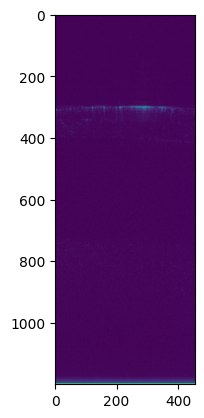

In [3]:
plt.imshow(original_data[0])

In [4]:
original_data = original_data[:,200:,:]

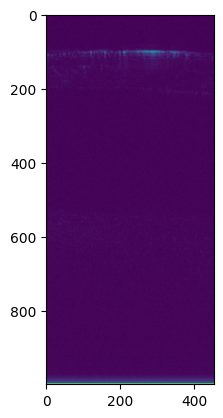

In [5]:
plt.imshow(original_data[0])

In [6]:
mid = find_mid(original_data)
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]

# intial correcting the y-motion
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

# finding the bright points in all images to crop the standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-80,np.max(nn)+80
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]

print(UP,DOWN)

warping: 100%|██████████| 500/500 [00:07<00:00, 63.95it/s]


22 182


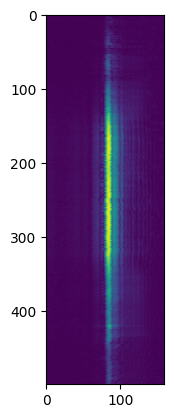

In [7]:
plt.imshow(original_data[:,UP:DOWN,:][:,:,400])

In [8]:
# better correcting the y-motion using functions
tr_all = ants_all_trans(original_data,UP,DOWN) # fucntion definition in util_funcs.py
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)



warping: 100%|██████████| 500/500 [00:06<00:00, 75.56it/s]


In [9]:
original_data[:,UP:DOWN,:].shape

(500, 160, 454)

In [63]:
temp_img = original_data[:,UP:DOWN,:][:,95,:].copy()

tp = fft2(temp_img).flatten()
tp[tp.shape[0]//2:] = 0
# tp = np.where(np.abs(tp)>7.7,tp,0)
temp_img = ifft2(tp.reshape(temp_img.shape)).real

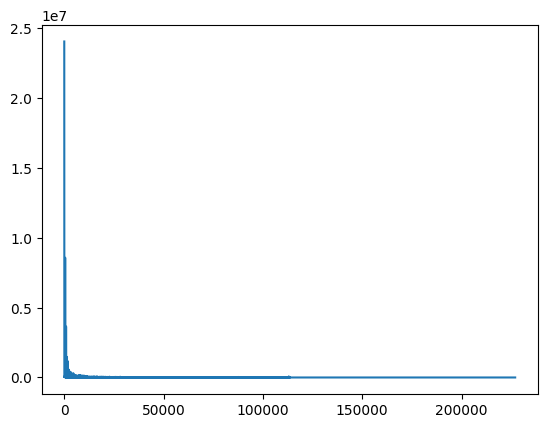

In [64]:
plt.plot(np.abs(tp))

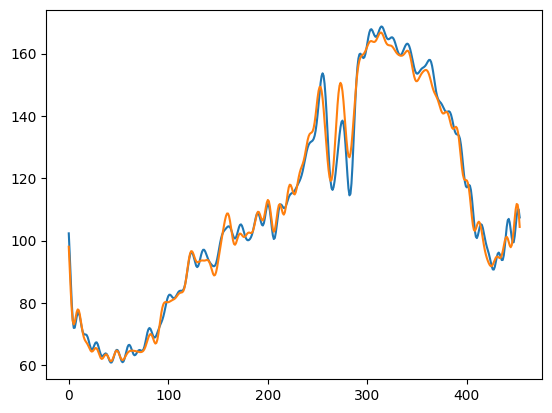

In [65]:
plt.plot(denoise_signal(temp_img[100],rows=50))
plt.plot(denoise_signal(temp_img[101],rows=50))

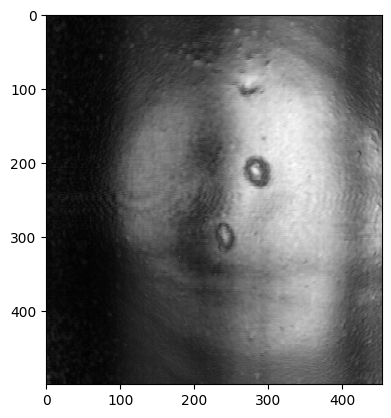

In [66]:
plt.imshow(temp_img,cmap='gray')

In [75]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=1)
    y = scp.shift(y, past_shift,order=1)

    warped_x_stat = scp.shift(x, -shif[0],order=1)
    warped_y_mov = scp.shift(y, shif[0],order=1)

    return (1-ncc1d(warped_x_stat ,warped_y_mov))

def denoise_signal(errs , rows = 10):
    kk = fft(errs)
    kk[rows:] = 0
    kk = abs(ifft(kk))
    return kk

In [76]:
kk = []
for i in tqdm(range(temp_img.shape[0]-1)):
        st = denoise_signal(temp_img[i],rows=50)
        mv = denoise_signal(temp_img[i+1],rows=50)
        rt = 0
        past_shift = 0
        for _ in range(10):
                move = minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-2,2)]),
                        args = (st
                                ,mv
                                ,past_shift))['x']

                past_shift += move
                rt+=move
        kk.append(rt*2)

100%|██████████| 499/499 [00:55<00:00,  8.98it/s]


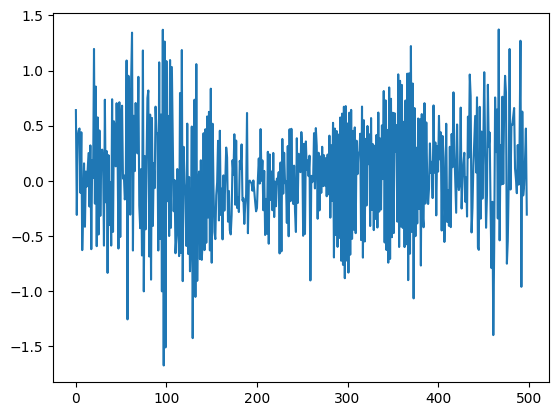

In [77]:
plt.plot(kk)

In [15]:
# temp_img = original_data[:,UP:DOWN,:][:,95,:].copy()
# for i in range(len(kk)):
#     temp_img[i+1] = scp.shift(temp_img[i+1],kk[i])

gg = original_data.copy()
moves = [-0.73,0.73]*original_data.shape[0]
for i in tqdm(range(original_data.shape[0]-1)):
    gg[i+1] = scp.shift(gg[i+1],shift = (0,-moves[i]),order=3)
# for i in range(len(kk)):
#     original_data[i+1] = scp.shift(original_data[i+1],shift = (0,kk[i][0]),order=3)

100%|██████████| 499/499 [00:19<00:00, 25.47it/s]


In [16]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(original_data)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

500it [00:02, 245.64it/s]
